In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import os

In [2]:
os.chdir(r'C:\SML_Projects\SML_CVE_type_cwe_predict')

In [3]:
df = pd.read_csv("data/engineered/engineered_dataset.csv")

In [4]:
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cve_id                      10296 non-null  object 
 1   description                 10296 non-null  object 
 2   cvss_score                  10296 non-null  object 
 3   cwe                         10296 non-null  object 
 4   vendor                      10296 non-null  object 
 5   product                     10296 non-null  object 
 6   publish_date                10296 non-null  object 
 7   type                        10296 non-null  object 
 8   vendor_freq                 10296 non-null  float64
 9   product_freq                10296 non-null  float64
 10  desc_len                    10296 non-null  int64  
 11  desc_word_count             10296 non-null  int64  
 12  desc_num_count              10296 non-null  int64  
 13  desc_upper_ratio            102

In [6]:
from sklearn.preprocessing import LabelEncoder

df_fixed = df.copy()

le_type = LabelEncoder()
le_cwe = LabelEncoder()

df_fixed['type'] = le_type.fit_transform(df_fixed['type'])
df_fixed['cvss_score'] = le_cwe.fit_transform(df_fixed['cvss_score'])

numeric_features = df_fixed.select_dtypes(include=['int64', 'float64']).drop(columns=['type', 'cvss_score'])
target = df_fixed[['type', 'cvss_score']]

# Pearson
pearson_type = numeric_features.corrwith(target['type'])
pearson_cvss = numeric_features.corrwith(target['cvss_score'])

print("Pearson correlation with TYPE:\n", pearson_type)
print("\nPearson correlation with CVSS_SCORE:\n", pearson_cvss)

# Spearman
spearman_type = numeric_features.corrwith(target['type'], method='spearman')
spearman_cvss = numeric_features.corrwith(target['cvss_score'], method='spearman')
print("\nSpearman correlation with TYPE:\n", spearman_type)
print("\nSpearman correlation with CVSS_SCORE:\n", spearman_cvss)

Pearson correlation with TYPE:
 vendor_freq                  -0.192324
product_freq                 -0.156224
desc_len                     -0.062430
desc_word_count              -0.059332
desc_num_count               -0.074734
desc_upper_ratio              0.046707
desc_exclamation             -0.024136
desc_question                -0.027434
vendor_product_interaction   -0.148746
XSS_score                     0.685866
SQLi_score                    0.255051
RCE_score                     0.139287
DoS_score                    -0.273130
CSRF_score                   -0.134223
AuthBypass_score             -0.160606
PrivEsc_score                -0.000939
PathTraversal_score          -0.017328
SSRF_score                    0.083937
InfoDisclosure_score         -0.124155
Other_score                  -0.046569
cvss_keywords_score          -0.097269
dtype: float64

Pearson correlation with CVSS_SCORE:
 vendor_freq                   0.142177
product_freq                  0.150063
desc_len         

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cve_id                      10296 non-null  object 
 1   description                 10296 non-null  object 
 2   cvss_score                  10296 non-null  object 
 3   cwe                         10296 non-null  object 
 4   vendor                      10296 non-null  object 
 5   product                     10296 non-null  object 
 6   publish_date                10296 non-null  object 
 7   type                        10296 non-null  object 
 8   vendor_freq                 10296 non-null  float64
 9   product_freq                10296 non-null  float64
 10  desc_len                    10296 non-null  int64  
 11  desc_word_count             10296 non-null  int64  
 12  desc_num_count              10296 non-null  int64  
 13  desc_upper_ratio            102

In [8]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import f_oneway

categorical_features = df.select_dtypes(include=['object']).columns

df_fixed = df.copy()

le_type = LabelEncoder()
le_cvss = LabelEncoder()
df_fixed['type_num'] = le_type.fit_transform(df_fixed['type'])
df_fixed['cvss_num'] = le_cvss.fit_transform(df_fixed['cvss_score'])

targets = ['type_num', 'cvss_num']

anova_results = {}

for target_col in targets:
    anova_results[target_col] = {}
    for col in categorical_features:
        if col in ['type', 'cvss_score']:  
            continue
        groups = [df_fixed[df_fixed[col] == val][target_col] for val in df_fixed[col].unique()]
        valid_groups = [g for g in groups if len(g) > 1]
        if len(valid_groups) > 1:
            f_stat, p_val = f_oneway(*valid_groups)
            anova_results[target_col][col] = {'F-statistic': f_stat, 'p-value': p_val}

for target_col in targets:
    print(f"\nANOVA Results for Categorical Features vs {target_col}:\n")
    anova_df = pd.DataFrame(anova_results[target_col]).T.sort_values('p-value')
    print(anova_df)


ANOVA Results for Categorical Features vs type_num:

              F-statistic       p-value
description   2273.486580  0.000000e+00
cwe             64.708373  0.000000e+00
vendor           6.044786  0.000000e+00
product          5.220180  0.000000e+00
publish_date     2.179077  1.046575e-68

ANOVA Results for Categorical Features vs cvss_num:

              F-statistic        p-value
cwe             12.568988   0.000000e+00
product          3.222075  4.951691e-191
description     55.082993  2.302186e-187
vendor           3.470870  5.184322e-187
publish_date     1.715223   5.119846e-32


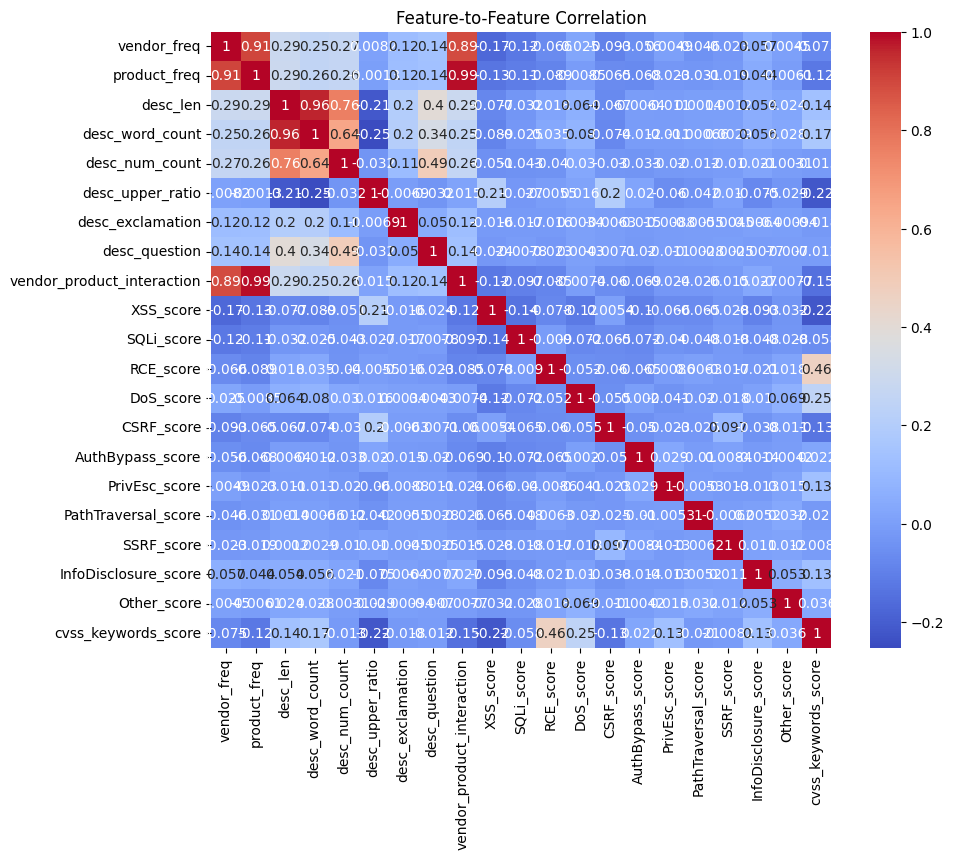

Highly correlated features to drop: ['product_freq', 'desc_word_count', 'vendor_product_interaction']


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features.columns].corr(), annot=True, cmap='coolwarm')
plt.title("Feature-to-Feature Correlation")
plt.show()

corr_matrix = df[numeric_features.columns].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Highly correlated features to drop:", to_drop)

In [10]:
import plotly.express as px
import numpy as np
import pandas as pd

corr_matrix = df[numeric_features.columns].corr()

fig = px.imshow(
    corr_matrix,
    text_auto=True,         
    color_continuous_scale='RdBu_r',
    origin='upper',
    labels=dict(x="Features", y="Features", color="Correlation"),
    title="Feature-to-Feature Correlation (Numeric Features)"
)
fig.update_xaxes(side="top")
fig.show()

upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
print("Highly correlated features to drop:", to_drop)

Highly correlated features to drop: ['product_freq', 'desc_word_count', 'vendor_product_interaction']


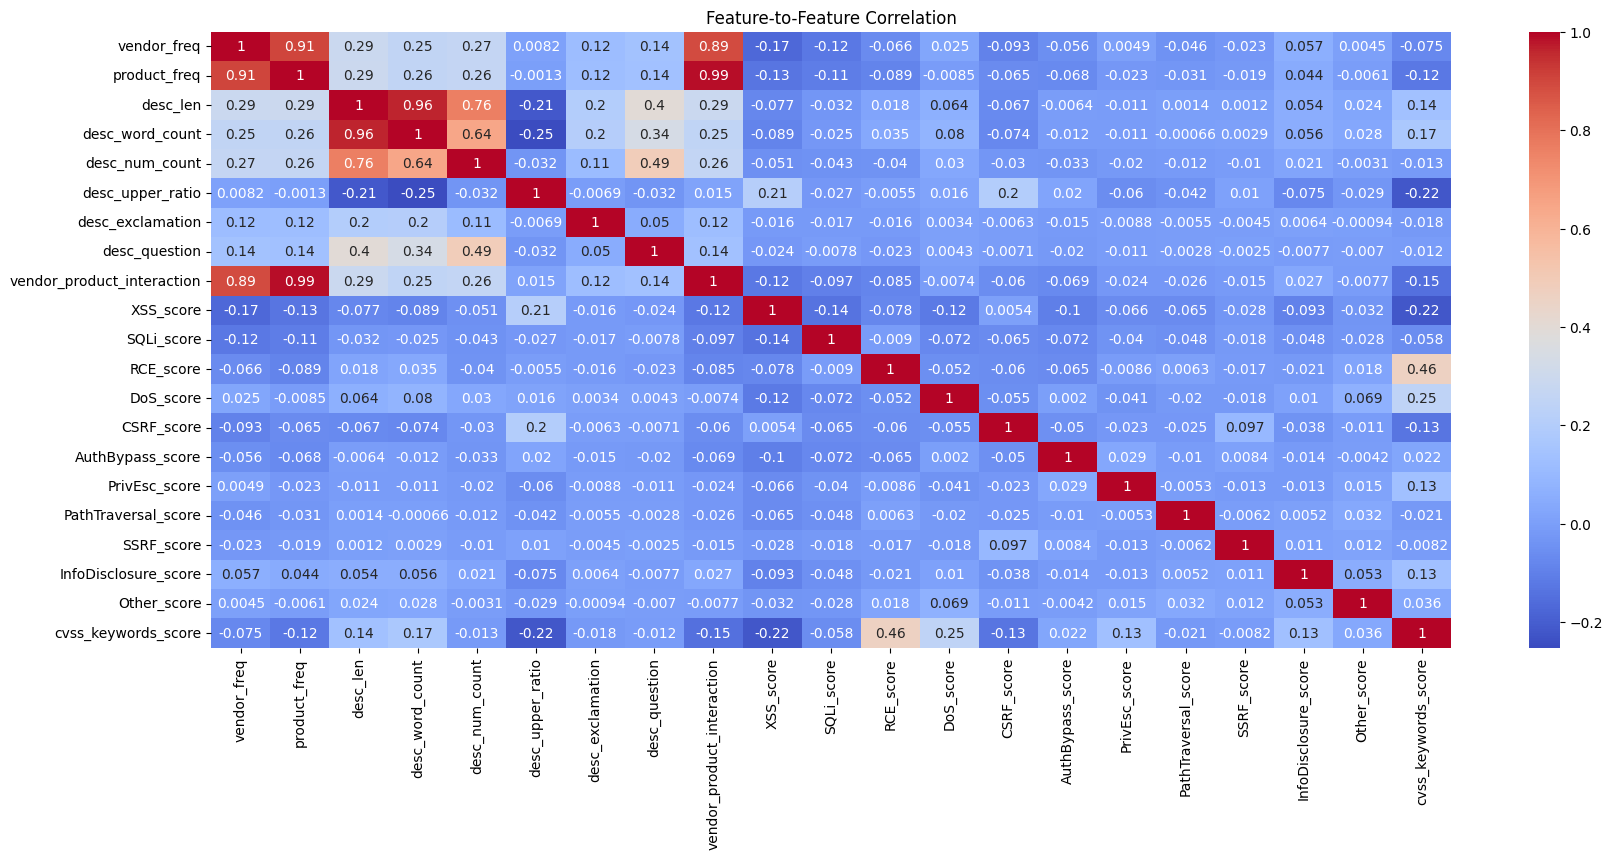

Highly correlated features to drop: ['product_freq', 'desc_word_count', 'vendor_product_interaction']


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
sns.heatmap(df[numeric_features.columns].corr(), annot=True, cmap='coolwarm')
plt.title("Feature-to-Feature Correlation")
plt.show()

corr_matrix = df[numeric_features.columns].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Highly correlated features to drop:", to_drop)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler

X = numeric_features
y = target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LinearRegression()
lr.fit(X_scaled, y)

coefficients = pd.DataFrame(lr.coef_, columns=X.columns, index=y.columns)
print("Linear Regression Feature Coefficients:\n", coefficients)

Linear Regression Feature Coefficients:
             vendor_freq  product_freq  desc_len  desc_word_count  \
type          -0.068202      0.269462 -0.134733         0.142043   
cvss_score     0.115877      0.306987 -0.108832         0.217895   

            desc_num_count  desc_upper_ratio  desc_exclamation  desc_question  \
type             -0.022081         -0.190510         -0.005848       0.004763   
cvss_score       -0.043783         -0.080704         -0.007942       0.015004   

            vendor_product_interaction  XSS_score  ...  RCE_score  DoS_score  \
type                         -0.236952   2.051359  ...   0.487569  -0.425981   
cvss_score                   -0.278171   0.196015  ...  -0.244340   0.010620   

            CSRF_score  AuthBypass_score  PrivEsc_score  PathTraversal_score  \
type         -0.317134         -0.154843       0.142640             0.104905   
cvss_score    0.037859          0.043321      -0.095509            -0.005388   

            SSRF_score  Info

In [ ]:
rf = MultiOutputClassifier(RandomForestRegressor(random_state=42))
rf.fit(X, y)

feat_importances = {}
for i, col in enumerate(y.columns):
    feat_importances[col] = pd.Series(rf.estimators_[i].feature_importances_, index=X.columns).sort_values(ascending=False)

for target_col, importance in feat_importances.items():
    print(f"\nRandom Forest Feature Importance for {target_col}:\n", importance)


Random Forest Feature Importance for type:
 XSS_score                     0.541047
SQLi_score                    0.142962
RCE_score                     0.063364
desc_len                      0.031651
desc_upper_ratio              0.031643
CSRF_score                    0.028082
desc_word_count               0.022238
vendor_product_interaction    0.020879
DoS_score                     0.020557
desc_num_count                0.019438
vendor_freq                   0.018442
product_freq                  0.015375
SSRF_score                    0.014904
cvss_keywords_score           0.014134
PrivEsc_score                 0.005679
PathTraversal_score           0.003300
AuthBypass_score              0.002521
InfoDisclosure_score          0.002497
Other_score                   0.000718
desc_question                 0.000558
desc_exclamation              0.000014
dtype: float64

Random Forest Feature Importance for cvss_score:
 desc_upper_ratio              0.148631
desc_len                      0

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

X = df.select_dtypes(include=['int64', 'float64'])

df_fixed = df.copy()
le_type = LabelEncoder()
le_cvss = LabelEncoder()
df_fixed['type_num'] = le_type.fit_transform(df_fixed['type'])
df_fixed['cvss_num'] = le_cvss.fit_transform(df_fixed['cvss_score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf_full = MultiOutputClassifier(RandomForestClassifier(random_state=42))
clf_full.fit(X_train, y_train)
y_pred_full = clf_full.predict(X_test)

full_accuracy = {col: accuracy_score(y_test[col], y_pred_full[:, i]) for i, col in enumerate(y.columns)}

feat_importances = pd.Series(clf_full.estimators_[0].feature_importances_, index=X.columns)
feature_to_drop = feat_importances.idxmin() 

X_train_reduced = X_train.drop(columns=[feature_to_drop])
X_test_reduced = X_test.drop(columns=[feature_to_drop])

clf_reduced = MultiOutputClassifier(RandomForestClassifier(random_state=42))
clf_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = clf_reduced.predict(X_test_reduced)

reduced_accuracy = {col: accuracy_score(y_test[col], y_pred_reduced[:, i]) for i, col in enumerate(y.columns)}

print(f"\nFull model Accuracy per target: {full_accuracy}")
print(f"Reduced model Accuracy per target (dropped {feature_to_drop}): {reduced_accuracy}")


Full model Accuracy per target: {'type': 0.8332793784396245, 'cvss_score': 0.6581417934606669}
Reduced model Accuracy per target (dropped desc_exclamation): {'type': 0.832308190352865, 'cvss_score': 0.6539333117513758}
